<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#split_data" data-toc-modified-id="split_data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>split_data</a></span></li></ul></div>

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
def dummy_feature(df, variables):
    dummies = pd.DataFrame()
    for var in variables:
        dummy = pd.get_dummies(df[var], prefix=var, drop_first=True)
        dummies = pd.concat([dummies, dummy], axis=1)
        df = df.drop(var, axis=1)
    df = pd.concat([df, dummies], axis=1)
    return df

def preprocessing_data(data):
    data['height'] = data['height/weight'].apply(lambda x: np.nan if str(x) == 'nan' else x.split('/')[0][:3]).astype(float)
    data['weight'] = data['height/weight'].apply(lambda x: np.nan if str(x) == 'nan' else x.split('/')[1][:-2]).astype(float)
    data['age'] = data.year - data.year_born.apply(lambda x: int(x[:4]))
    data.starting_salary = data.starting_salary.apply(lambda x: x[:-2] if str(x)!='nan' else np.nan).astype(float) 
    
    data = dummy_feature(data, ['team','position'])
    data = data.drop('year_born', axis=1)
    data = data.drop('height/weight', axis=1)
    
    data.starting_salary = data.starting_salary.fillna(np.median(data.starting_salary.dropna()))
    data.height = data.height.fillna(np.median(data.height.dropna()))
    data.weight = data.weight.fillna(np.median(data.weight.dropna()))
    data = data.fillna(0)
    
    return data

In [62]:
data = pd.read_csv('../dataset/Regular_Season_Batter.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2454 entries, 0 to 344
Data columns (total 28 columns):
batter_name        2454 non-null object
year               2454 non-null int64
team               2454 non-null object
avg                2428 non-null float64
G                  2454 non-null int64
AB                 2454 non-null int64
R                  2454 non-null int64
H                  2454 non-null int64
2B                 2454 non-null int64
3B                 2454 non-null int64
HR                 2454 non-null int64
TB                 2454 non-null int64
RBI                2454 non-null int64
SB                 2454 non-null int64
CS                 2454 non-null int64
BB                 2454 non-null int64
HBP                2454 non-null int64
SO                 2454 non-null int64
GDP                2454 non-null int64
SLG                2428 non-null float64
OBP                2430 non-null float64
E                  2454 non-null int64
height/weight      1652 non-

In [63]:
features = ['year','team','height/weight','year_born','position','starting_salary','OPS']
data = data[features]

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2454 entries, 0 to 344
Data columns (total 7 columns):
year               2454 non-null int64
team               2454 non-null object
height/weight      1652 non-null object
year_born          2454 non-null object
position           1652 non-null object
starting_salary    1387 non-null object
OPS                2428 non-null float64
dtypes: float64(1), int64(1), object(5)
memory usage: 153.4+ KB


In [65]:
data = preprocessing_data(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2454 entries, 0 to 344
Data columns (total 30 columns):
year                  2454 non-null int64
starting_salary       2454 non-null float64
OPS                   2454 non-null float64
height                2454 non-null float64
weight                2454 non-null float64
age                   2454 non-null int64
team_KT               2454 non-null uint8
team_LG               2454 non-null uint8
team_NC               2454 non-null uint8
team_OB               2454 non-null uint8
team_SK               2454 non-null uint8
team_넥센               2454 non-null uint8
team_두산               2454 non-null uint8
team_롯데               2454 non-null uint8
team_삼성               2454 non-null uint8
team_쌍방울              2454 non-null uint8
team_우리               2454 non-null uint8
team_한화               2454 non-null uint8
team_해태               2454 non-null uint8
team_현대               2454 non-null uint8
team_히어로즈             2454 non-null uint8
posi

# split_data

In [66]:
x_data = data.drop('OPS',axis=1)
y_data = data.OPS

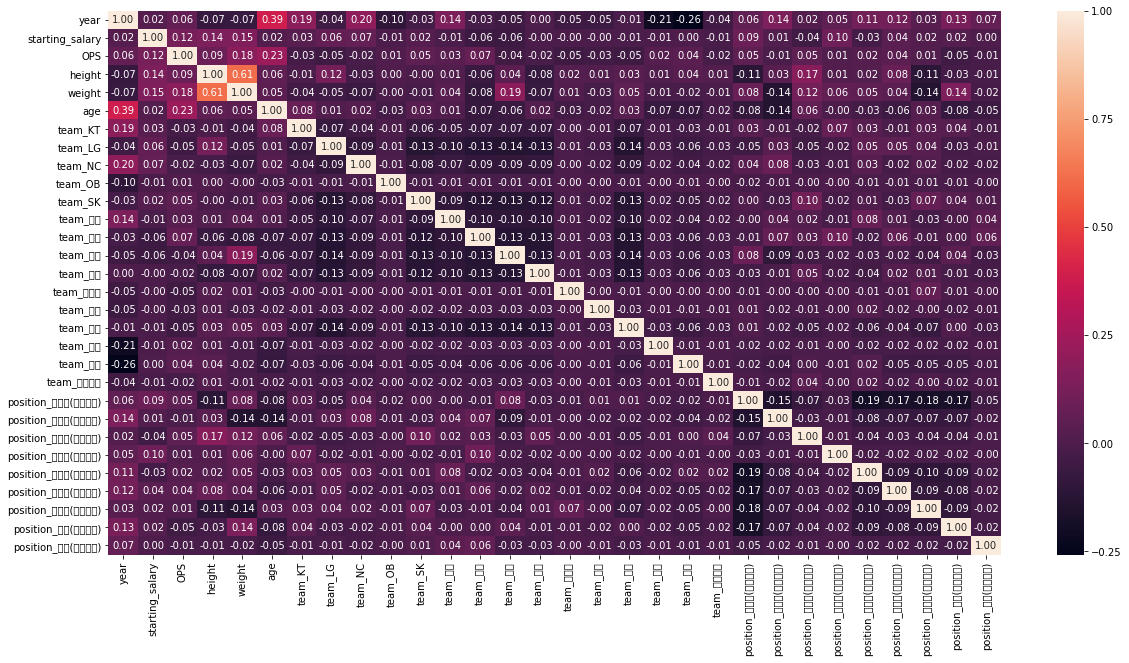

In [67]:
f, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", ax=ax)
plt.show()

In [68]:
x_train = x_data[(x_data.year != 2018) & (x_data.year != 2017)]
x_valid = x_data[x_data.year == 2017]
x_test = x_data[x_data.year == 2018]

y_train = y_data[(x_data.year != 2018) & (x_data.year != 2017)]
y_valid = y_data[x_data.year == 2017]
y_test = y_data[x_data.year == 2018]

In [69]:
x_train = x_train.drop('year', axis=1)
x_valid = x_valid.drop('year', axis=1)
x_test = x_test.drop('year', axis=1)

In [70]:
import xgboost as xgb

In [71]:
params = {
    "learning_rate": 0.1,
    "n_estimators": 10000,
    "max_depth": 3,
    "min_child_weight": 5,
    "subsample": 1.0,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "alpha": 0,
    "lambda": 1,
    "objective": "gpu:reg:linear",
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "eval_metric":"rmse"
}
model = xgb.XGBRegressor(**params)

In [72]:
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], early_stopping_rounds=100, verbose=1)

[0]	validation_0-rmse:0.298089	validation_1-rmse:0.279797
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:0.292188	validation_1-rmse:0.272517
[2]	validation_0-rmse:0.285815	validation_1-rmse:0.262732
[3]	validation_0-rmse:0.280051	validation_1-rmse:0.25579
[4]	validation_0-rmse:0.276116	validation_1-rmse:0.251038
[5]	validation_0-rmse:0.272745	validation_1-rmse:0.247136
[6]	validation_0-rmse:0.27003	validation_1-rmse:0.24397
[7]	validation_0-rmse:0.266883	validation_1-rmse:0.239137
[8]	validation_0-rmse:0.264879	validation_1-rmse:0.236745
[9]	validation_0-rmse:0.263657	validation_1-rmse:0.235065
[10]	validation_0-rmse:0.261104	validation_1-rmse:0.231014
[11]	validation_0-rmse:0.259907	validation_1-rmse:0.229579
[12]	validation_0-rmse:0.25872	validation_1-rmse:0.228166
[13]	validation_0-rmse:0.257734	validation_1-rmse:0.227005
[14]	validation_0-rmse:0.255

[137]	validation_0-rmse:0.229616	validation_1-rmse:0.213322
[138]	validation_0-rmse:0.229568	validation_1-rmse:0.21318
[139]	validation_0-rmse:0.229359	validation_1-rmse:0.213343
[140]	validation_0-rmse:0.229253	validation_1-rmse:0.213279
[141]	validation_0-rmse:0.228949	validation_1-rmse:0.213385
[142]	validation_0-rmse:0.228936	validation_1-rmse:0.213351
[143]	validation_0-rmse:0.228799	validation_1-rmse:0.213295
[144]	validation_0-rmse:0.228681	validation_1-rmse:0.213181
[145]	validation_0-rmse:0.228644	validation_1-rmse:0.213177
[146]	validation_0-rmse:0.22863	validation_1-rmse:0.213157
[147]	validation_0-rmse:0.22862	validation_1-rmse:0.21313
[148]	validation_0-rmse:0.228598	validation_1-rmse:0.213142
[149]	validation_0-rmse:0.228567	validation_1-rmse:0.213379
[150]	validation_0-rmse:0.22851	validation_1-rmse:0.21336
[151]	validation_0-rmse:0.228462	validation_1-rmse:0.213424
[152]	validation_0-rmse:0.228356	validation_1-rmse:0.213436
[153]	validation_0-rmse:0.228348	validation_1-

[275]	validation_0-rmse:0.219538	validation_1-rmse:0.213359
[276]	validation_0-rmse:0.219472	validation_1-rmse:0.213441
[277]	validation_0-rmse:0.219387	validation_1-rmse:0.213336
Stopping. Best iteration:
[177]	validation_0-rmse:0.226524	validation_1-rmse:0.21268



XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.7, eval_metric='rmse', gamma=0, lambda=1,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=10000, n_jobs=1,
       nthread=None, objective='gpu:reg:linear', predictor='gpu_predictor',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0, tree_method='gpu_hist')

In [73]:
prob = model.predict(x_test, ntree_limit=model.best_iteration)
rmse = np.sqrt(np.mean(np.power(y_test-prob, 2)))
print('test RMSE: {0:.6f}'.format(rmse))

test RMSE: 0.231168


C:\Users\wogur\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


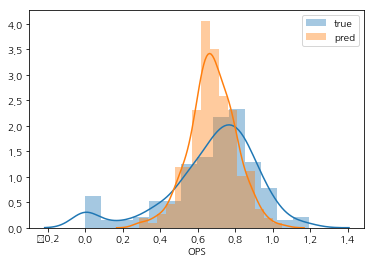

In [96]:
sns.distplot(y_test, label='true')
sns.distplot(prob, label='pred')
plt.legend(loc='upper right')

In [75]:
weight_score = model.get_booster().get_score(importance_type='weight')
gain_score = model.get_booster().get_score(importance_type='gain')
cover_score = model.get_booster().get_score(importance_type='cover')

weight_score_df = pd.DataFrame({'feature':list(weight_score.keys()), 'score':list(weight_score.values())})
gain_score_df = pd.DataFrame({'feature':list(gain_score.keys()), 'score':list(gain_score.values())})
cover_score_df = pd.DataFrame({'feature':list(cover_score.keys()), 'score':list(cover_score.values())})

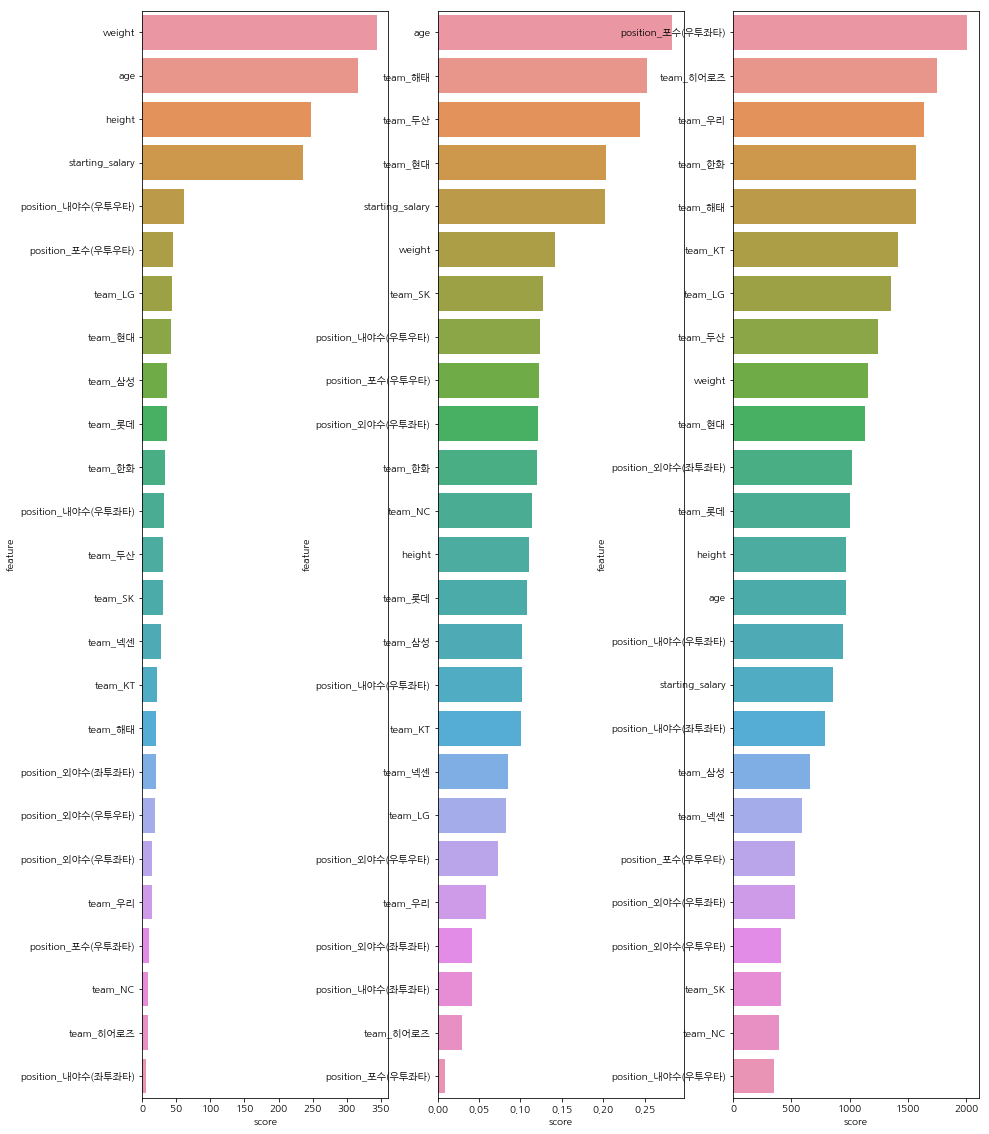

In [94]:
f, ax = plt.subplots(1,3, figsize=(15,20))
sns.barplot(x='score', y='feature', data=weight_score_df.sort_values(by='score', ascending=False), ax=ax[0])
sns.barplot(x='score', y='feature', data=gain_score_df.sort_values(by='score', ascending=False), ax=ax[1])
sns.barplot(x='score', y='feature', data=cover_score_df.sort_values(by='score', ascending=False), ax=ax[2])